In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(os.path.join("drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))
os.getcwd()

'/content/drive/Othercomputers/My Laptop/RP/urban-change-detection'

In [3]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 71.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cac

#### Imports


In [4]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from plots import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import levir_dataset_loader
import train_test
import hrscd_dataset_loader
from levir_dataset_loader import LEVIR_Dataset
from hrscd_dataset_loader import HRSCD_Dataset
import time



reload(hrscd_dataset_loader)
reload(metrics)


<module 'metrics' from '/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py'>

#### Load Data

In [5]:
N_EPOCHS = 10
FP_MODIFIER = 1
BATCH_SIZE = 1
PATCH_SIZE = 1024
STRIDE = 50
TEST_RUN = False
DIRNAME = os.path.join("..", "data", "HRSCD")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [6]:
# train_dataset = LEVIR_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)
# test_dataset = LEVIR_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
# val_dataset = LEVIR_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)

train_dataset = HRSCD_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)
test_dataset = HRSCD_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
val_dataset = HRSCD_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.FloatTensor(train_dataset.weights).to(device)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
net.to(device)

criterion = nn.NLLLoss(weight=weights)

In [7]:
import train_test
reload(train_test)
from train_test import train

save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics = train(net, net_name, train_dataset, train_loader, val_dataset, criterion, PATCH_SIZE, device, n_epochs=10, save=True, save_dir = save_dir)

  0%|          | 0/172 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 172/172 [00:11<00:00, 14.47it/s]
/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:62: RuntimeWarning: invalid value encountered in divide
  

In [8]:
reload(metrics)
from metrics import evaluate_categories

categorical_metrics = evaluate_categories(net, test_dataset, ["No info", "Artificial surfaces", "Agricultural Surfaces" "Forests", "Wetlands", "Water"], 1000)

/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:187: RuntimeWarning: invalid value encountered in divide
  cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))


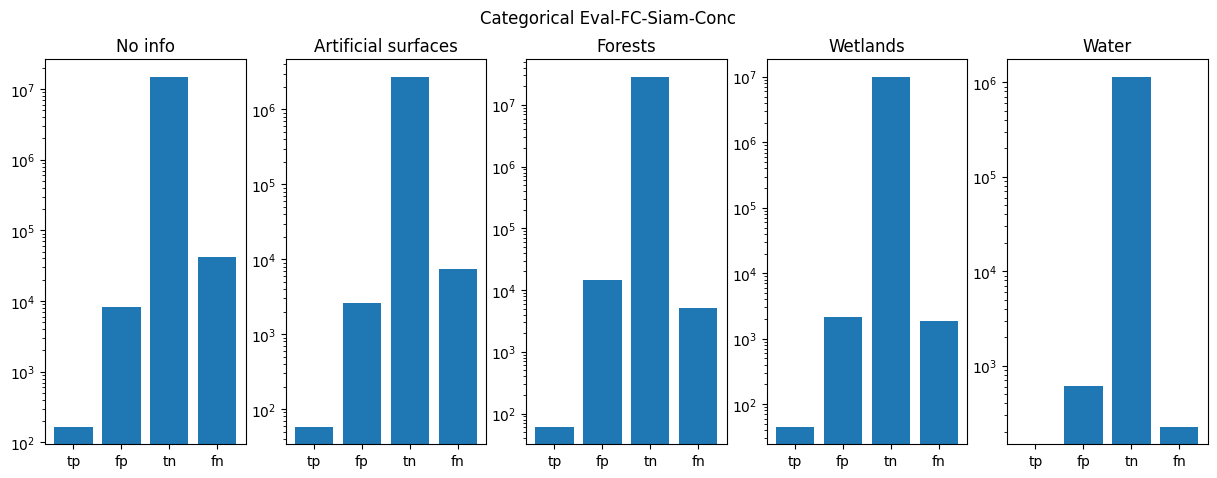

In [9]:
from plots import category_histograms

category_histograms('FC-Siam-Conc', 'Categorical Eval', categorical_metrics )

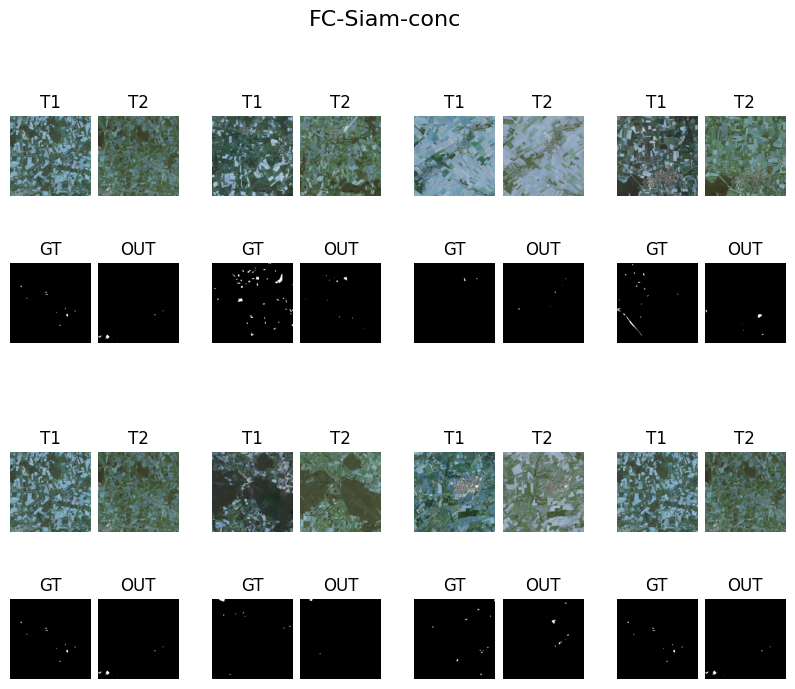

In [10]:
from data_examination import examine_subset

examine_subset(net, net_name, test_dataset, 10, device)

In [13]:
test_metrics = evaluate_net_predictions(net, criterion, test_dataset, PATCH_SIZE)

[0.08234345781697373, 0.173748992419035, 0.1553138053647254, 0.2382635266316609, 0.23977762019426985, 0.2766426161528743, 0.42273688630390494, 0.1904778418666032, 0.4356061757916707, 0.4473250914927325] [0.6721889494561349, 0.021169358786639555, 0.03614265583117374, 0.01810346204020963, 0.01887889863501268, 0.012005108120785346, 0.010918874289396512, 0.020407679613940626, 0.015823445479085152, 0.012986102694034631]




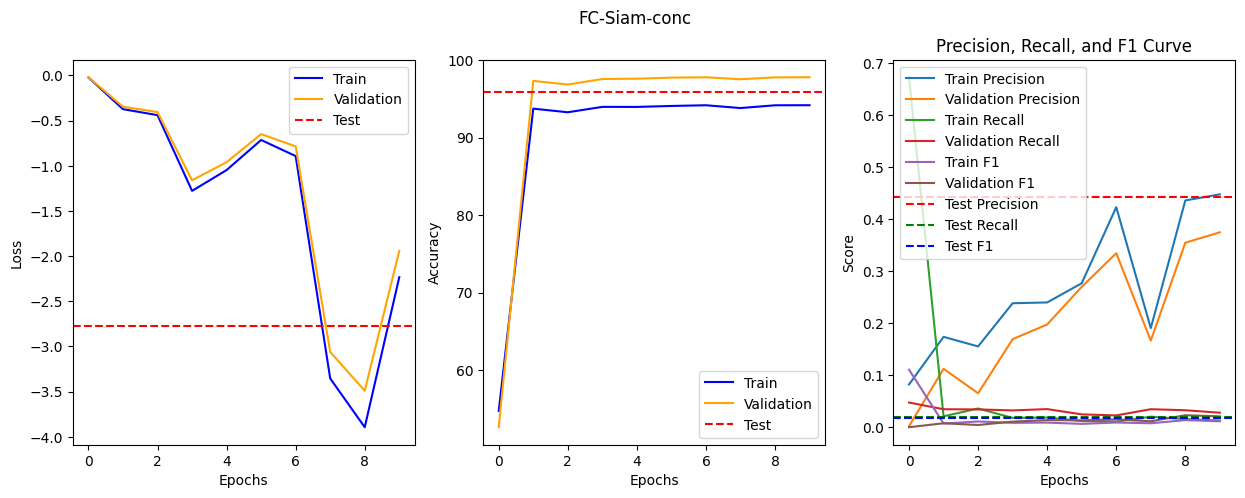

In [14]:
from tables import create_tables
from plots import create_figures


create_figures(training_metrics, test_metrics, net_name)
create_tables(training_metrics, test_metrics, net_name)